## TD N°2 explicabilité du dataset Boston Housing

1) Charger le dataset bostong_housing
   1) Disponible dans le folder 04_interpretable_ml/td/data/
   
2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest
   1) Tester d'ajouter des features log, quadratique, ...

3)Créer un modèle baseline linéaire et random forest

4) Interpréter le modèle linéaire

5) Tuner votre random forest

6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

6) Réaliser une explicabilité par individu
   1) En utilisant la méthode ICE (PDP individuelle)
   2) LIME (Model local pour expliquer une prédiction)
   3) SHAP watterfall plot (Contribution marginale de chaque variable dans la prédiction)

7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

## Contexte du Dataset

Le Boston Housing Dataset est un ensemble de données couramment utilisé en apprentissage automatique et en statistique pour étudier les relations entre diverses caractéristiques socio-économiques et immobilières dans la ville de Boston.  
Il contient des informations sur des propriétés résidentielles et leur environnement, et est souvent utilisé pour prédire la valeur des maisons, un problème classique de régression.

**Variable dispo**: 
- CRIM : taux de criminalité par habitant par ville
- ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : proportion de terrains commerciaux non commerciaux par ville
- CHAS : variable binaire indiquant la proximité de la rivière Charles (= 1 si la zone délimitée par la ville touche la rivière ; 0 sinon)
- NOX : concentration des oxydes d'azote (en parties par 10 millions)
- RM : nombre moyen de pièces par logement
- AGE : proportion des unités occupées par leur propriétaire et construites avant 1940
- DIS : distances pondérées vers cinq centres d'emploi de Boston
- RAD : indice d'accessibilité aux autoroutes radiales
- TAX : taux d'imposition foncière par valeur totale pour chaque tranche de 10 000 dollars
- PTRATIO : ratio élèves-enseignants par ville
- LSTAT : pourcentage de la population de statut socio-économique inférieur
- MEDV : valeur médiane des maisons occupées par leur propriétaire (en milliers de dollars) - **variable cible**

In [1]:
#Web request
import requests
import io
import pandas as pd

### 1) Charger le dataset bostong_housing

In [2]:
#Télécharge directement depuis Github
url = "https://raw.githubusercontent.com/Roulitoo/cours_iae/master/04_INTERPRETABLE_ML/td/data/boston_housing.csv" 
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   CRIM        506 non-null    float64
 2   ZN          506 non-null    float64
 3   INDUS       506 non-null    float64
 4   CHAS        506 non-null    int64  
 5   NOX         506 non-null    float64
 6   RM          506 non-null    float64
 7   AGE         506 non-null    float64
 8   DIS         506 non-null    float64
 9   RAD         506 non-null    int64  
 10  TAX         506 non-null    float64
 11  PTRATIO     506 non-null    float64
 12  LSTAT       506 non-null    float64
 13  MEDV        506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [4]:
df['RAD'] = df['RAD'].astype('category')
print(df.dtypes)

Unnamed: 0       int64
CRIM           float64
ZN             float64
INDUS          float64
CHAS             int64
NOX            float64
RM             float64
AGE            float64
DIS            float64
RAD           category
TAX            float64
PTRATIO        float64
LSTAT          float64
MEDV           float64
dtype: object


In [5]:
df = df.drop(columns=df.columns[0])

Nous pouvons voir dans notre jeux de données, que nous avons principalement des float64 donc des variable numérique donc quantitative continue. Nous avons la présence de 3 variables int64, donc une qui est binaire à savoir la variable CHAS, et les deux autres sont des quantitatives discrètes. 

### 2)Nettoyer votre jeu de données pour créer une régression linéaire et un random forest

Penser à :

- Vérifier comment encoder vos variables qualitatives pour la modélisation 
- Analyser les distributions
- Analyser les outliers 
- Analyser les corrélations

>Tester d'ajouter des features log, quadratique, ...

In [6]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,37.970000,50.000000


In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialiser le LabelEncoder
label_encoder = LabelEncoder()

# Appliquer LabelEncoder à la variable RAD
df['RAD'] = label_encoder.fit_transform(df['RAD'])

# Afficher un aperçu du DataFrame après encodage
print(df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    0  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    1  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    1  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    2  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    2  222.0   

   PTRATIO  LSTAT  MEDV  
0     15.3   4.98  24.0  
1     17.8   9.14  21.6  
2     17.8   4.03  34.7  
3     18.7   2.94  33.4  
4     18.7   5.33  36.2  


In [8]:
from sklearn.preprocessing import StandardScaler

# Sélectionner les colonnes de type float
float_columns = df.select_dtypes(include=['float64']).columns

# Initialiser le scaler
scaler = StandardScaler()

# Appliquer la standardisation uniquement sur les colonnes de type float
df[float_columns] = scaler.fit_transform(df[float_columns])

print(df)

         CRIM        ZN     INDUS  CHAS       NOX        RM       AGE  \
0   -0.419782  0.284830 -1.287909     0 -0.144217  0.413672 -0.120013   
1   -0.417339 -0.487722 -0.593381     0 -0.740262  0.194274  0.367166   
2   -0.417342 -0.487722 -0.593381     0 -0.740262  1.282714 -0.265812   
3   -0.416750 -0.487722 -1.306878     0 -0.835284  1.016303 -0.809889   
4   -0.412482 -0.487722 -1.306878     0 -0.835284  1.228577 -0.511180   
..        ...       ...       ...   ...       ...       ...       ...   
501 -0.413229 -0.487722  0.115738     0  0.158124  0.439316  0.018673   
502 -0.415249 -0.487722  0.115738     0  0.158124 -0.234548  0.288933   
503 -0.413447 -0.487722  0.115738     0  0.158124  0.984960  0.797449   
504 -0.407764 -0.487722  0.115738     0  0.158124  0.725672  0.736996   
505 -0.415000 -0.487722  0.115738     0  0.158124 -0.362767  0.434732   

          DIS  RAD       TAX   PTRATIO     LSTAT      MEDV  
0    0.140214    0 -0.666608 -1.459000 -1.075562  0.159686  
1

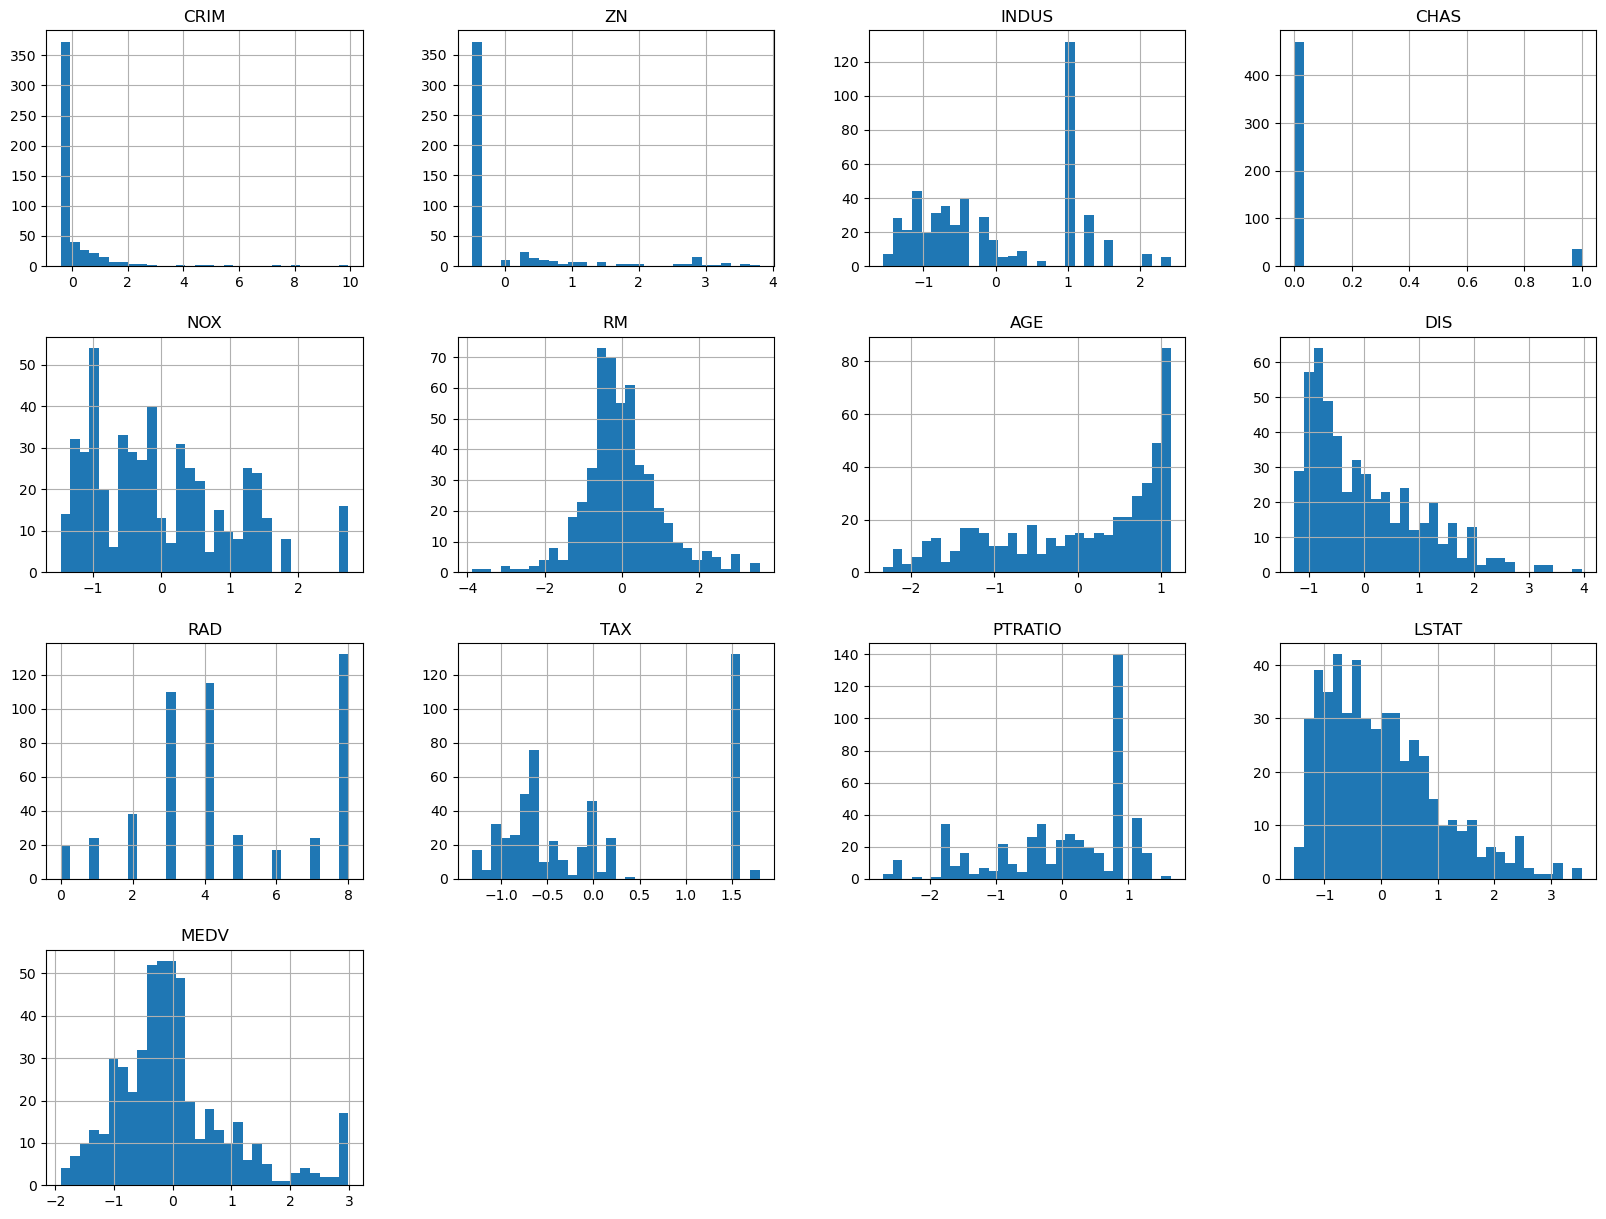

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms for all variables
df.hist(bins=30, figsize=(20, 15))
plt.show()

In [9]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)

CRIM       0.0
ZN         0.0
INDUS      0.0
CHAS       0.0
NOX        0.0
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        0.0
PTRATIO    0.0
LSTAT      0.0
MEDV       0.0
dtype: float64


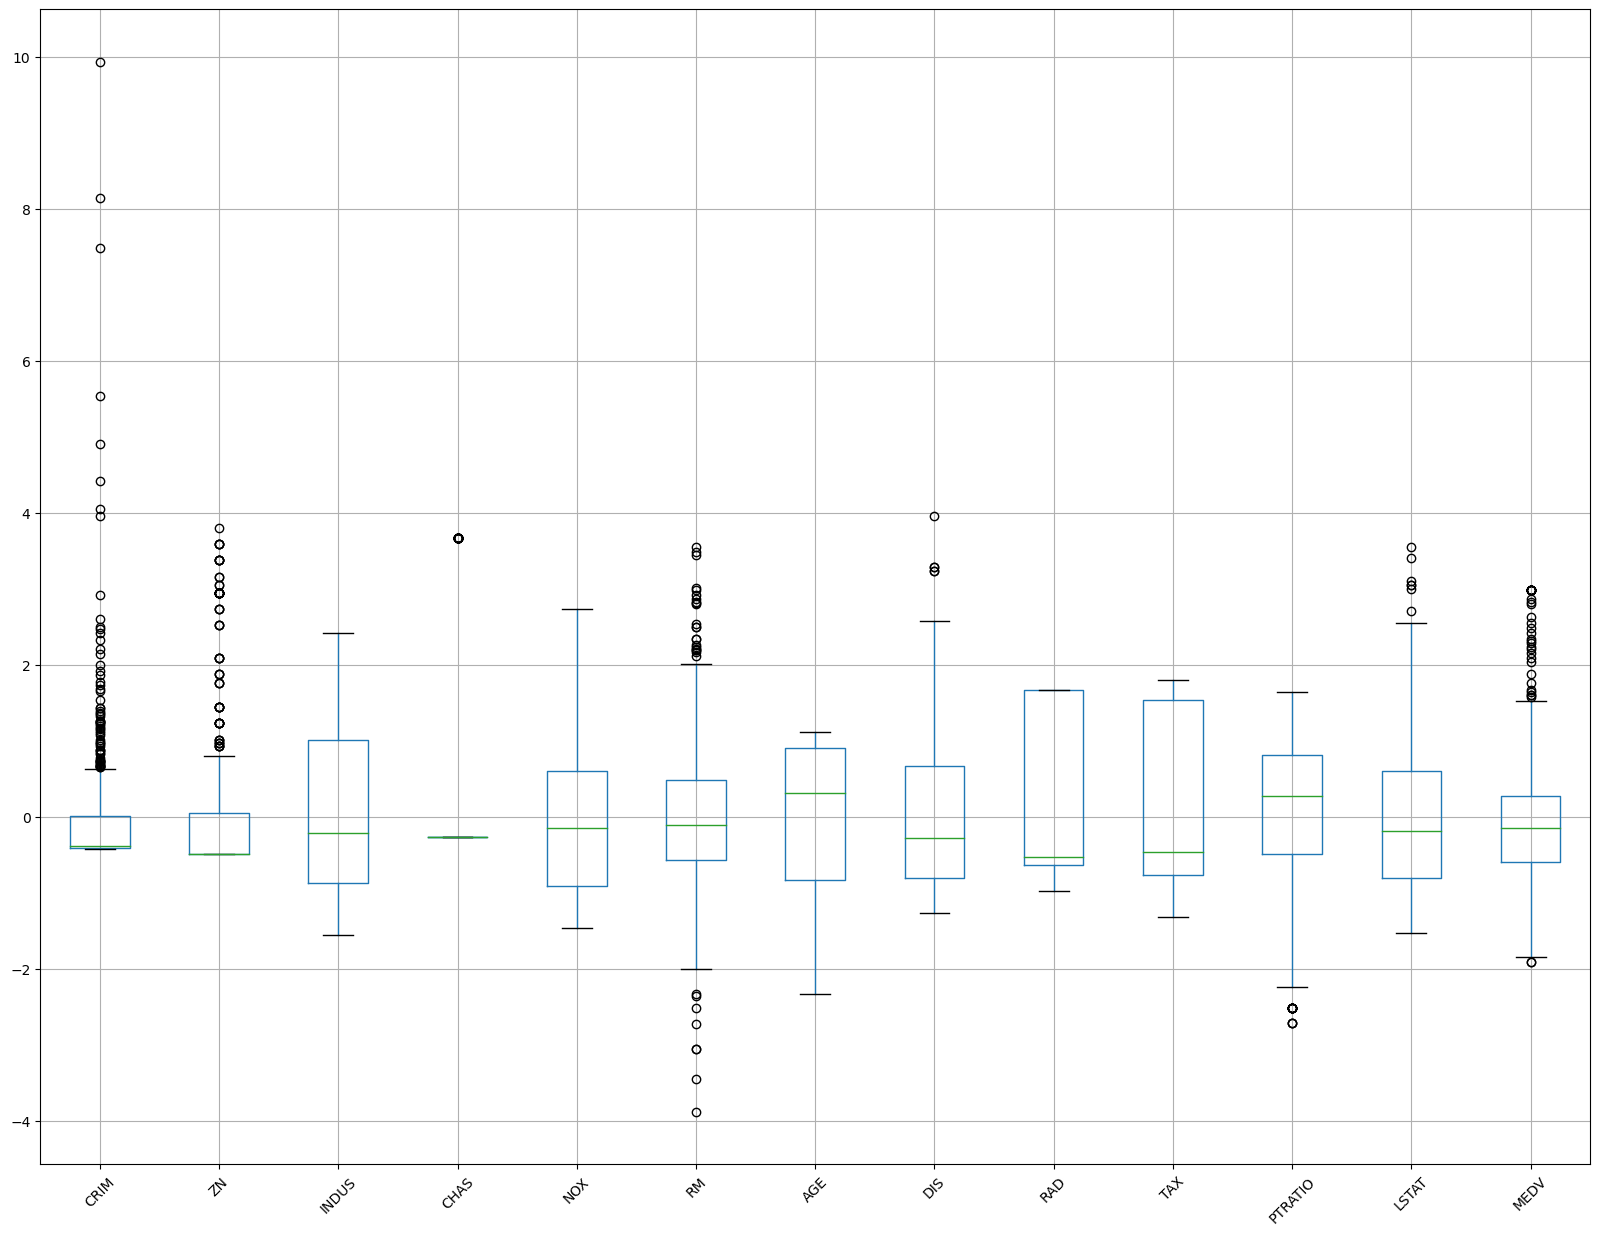

In [ ]:
# Create boxplots for all variables
df2.boxplot(figsize=(20, 15))
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Détecter les outliers 
def detect_outliers(df):
    outliers = {}
    
    for column in df.columns:
        # Calcul des quartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calcul des limites pour les outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Détection des outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers

# Détecter les outliers dans le dataset
outliers = detect_outliers(df)

# Afficher les outliers détectés pour chaque variable
for column, values in outliers.items():
    print(f"Outliers pour {column}:")
    print(values)
print("\n")

Outliers pour CRIM:
         CRIM        ZN     INDUS  CHAS       NOX        RM       AGE  \
367  1.153105 -0.487722  1.015999     0  0.659147 -3.450002  1.117494   
371  0.653875 -0.487722  1.015999     0  0.659147 -0.097781  1.117494   
373  0.872168 -0.487722  1.015999     0  0.978765 -1.964083  1.117494   
374  1.732178 -0.487722  1.015999     0  0.978765 -3.058221  1.117494   
375  1.861457 -0.487722  1.015999     0  1.004680  1.465070  1.042817   
..        ...       ...       ...   ...       ...       ...       ...   
468  1.392077 -0.487722  1.015999     0  0.218592 -0.510932  0.086238   
469  1.101074 -0.487722  1.015999     0  0.218592 -0.814384 -0.422278   
477  1.327804 -0.487722  1.015999     0  0.512296 -1.397069  1.021481   
478  0.770330 -0.487722  1.015999     0  0.512296 -0.141945  1.000145   
479  1.247542 -0.487722  1.015999     0  0.512296 -0.079260  0.690768   

          DIS  RAD       TAX   PTRATIO     LSTAT      MEDV  
367 -1.085954    8  1.530926  0.806576  0.

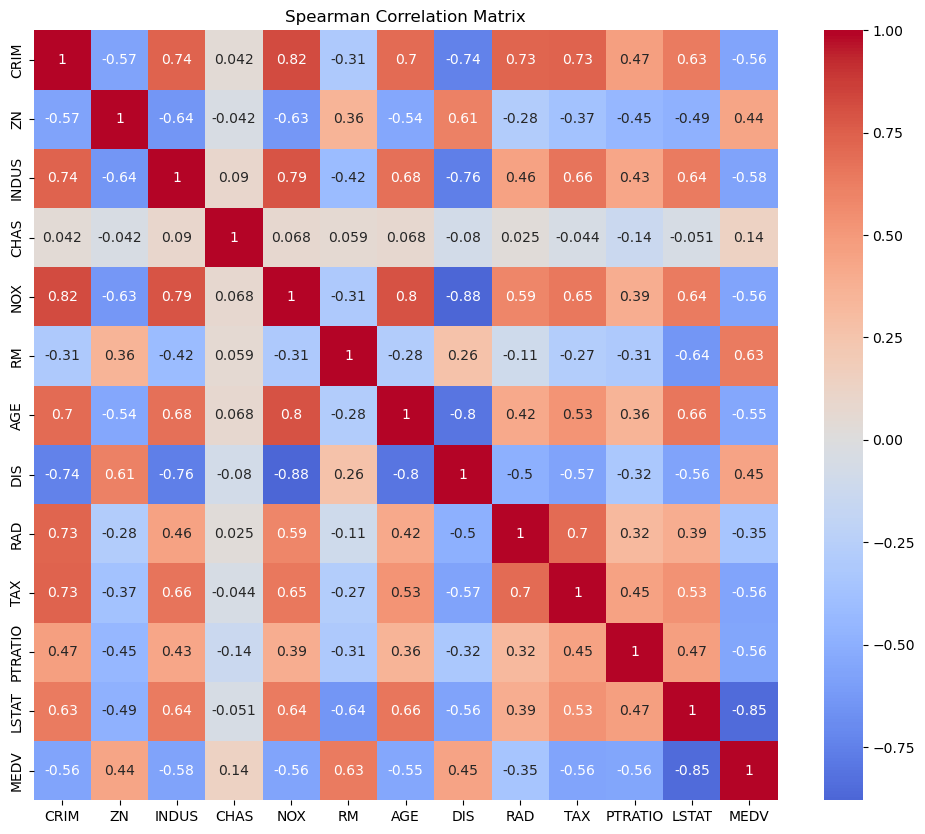

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculer la matrice de corrélation de Spearman
corr_matrix = df.corr(method='spearman')

# Afficher la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Matrix')
plt.show()

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features
df_clean = df.drop(columns=to_drop)
print(df_clean)

         CRIM        ZN     INDUS  CHAS       NOX        RM       AGE  \
0   -0.419782  0.284830 -1.287909     0 -0.144217  0.413672 -0.120013   
1   -0.417339 -0.487722 -0.593381     0 -0.740262  0.194274  0.367166   
2   -0.417342 -0.487722 -0.593381     0 -0.740262  1.282714 -0.265812   
3   -0.416750 -0.487722 -1.306878     0 -0.835284  1.016303 -0.809889   
4   -0.412482 -0.487722 -1.306878     0 -0.835284  1.228577 -0.511180   
..        ...       ...       ...   ...       ...       ...       ...   
501 -0.413229 -0.487722  0.115738     0  0.158124  0.439316  0.018673   
502 -0.415249 -0.487722  0.115738     0  0.158124 -0.234548  0.288933   
503 -0.413447 -0.487722  0.115738     0  0.158124  0.984960  0.797449   
504 -0.407764 -0.487722  0.115738     0  0.158124  0.725672  0.736996   
505 -0.415000 -0.487722  0.115738     0  0.158124 -0.362767  0.434732   

          DIS  RAD       TAX   PTRATIO     LSTAT      MEDV  
0    0.140214    0 -0.666608 -1.459000 -1.075562  0.159686  
1

In [10]:
print(df.dtypes)

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object


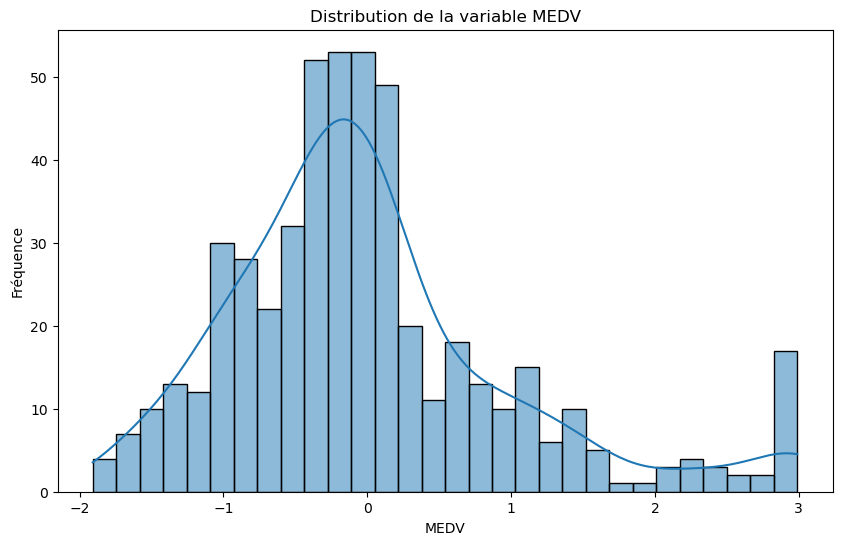

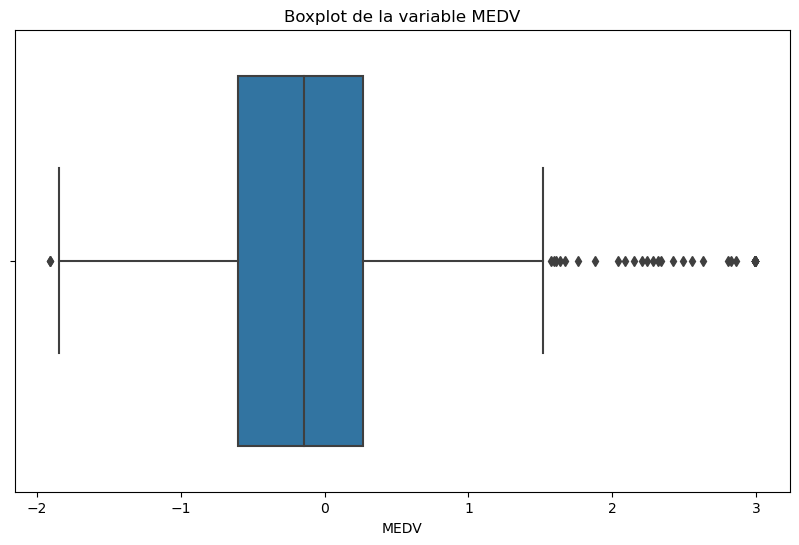

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Histogramme de la variable MEDV
plt.figure(figsize=(10, 6))
sns.histplot(df['MEDV'], bins=30, kde=True)
plt.title('Distribution de la variable MEDV')
plt.xlabel('MEDV')
plt.ylabel('Fréquence')
plt.show()

# Boxplot de la variable MEDV
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['MEDV'])
plt.title('Boxplot de la variable MEDV')
plt.xlabel('MEDV')
plt.show()


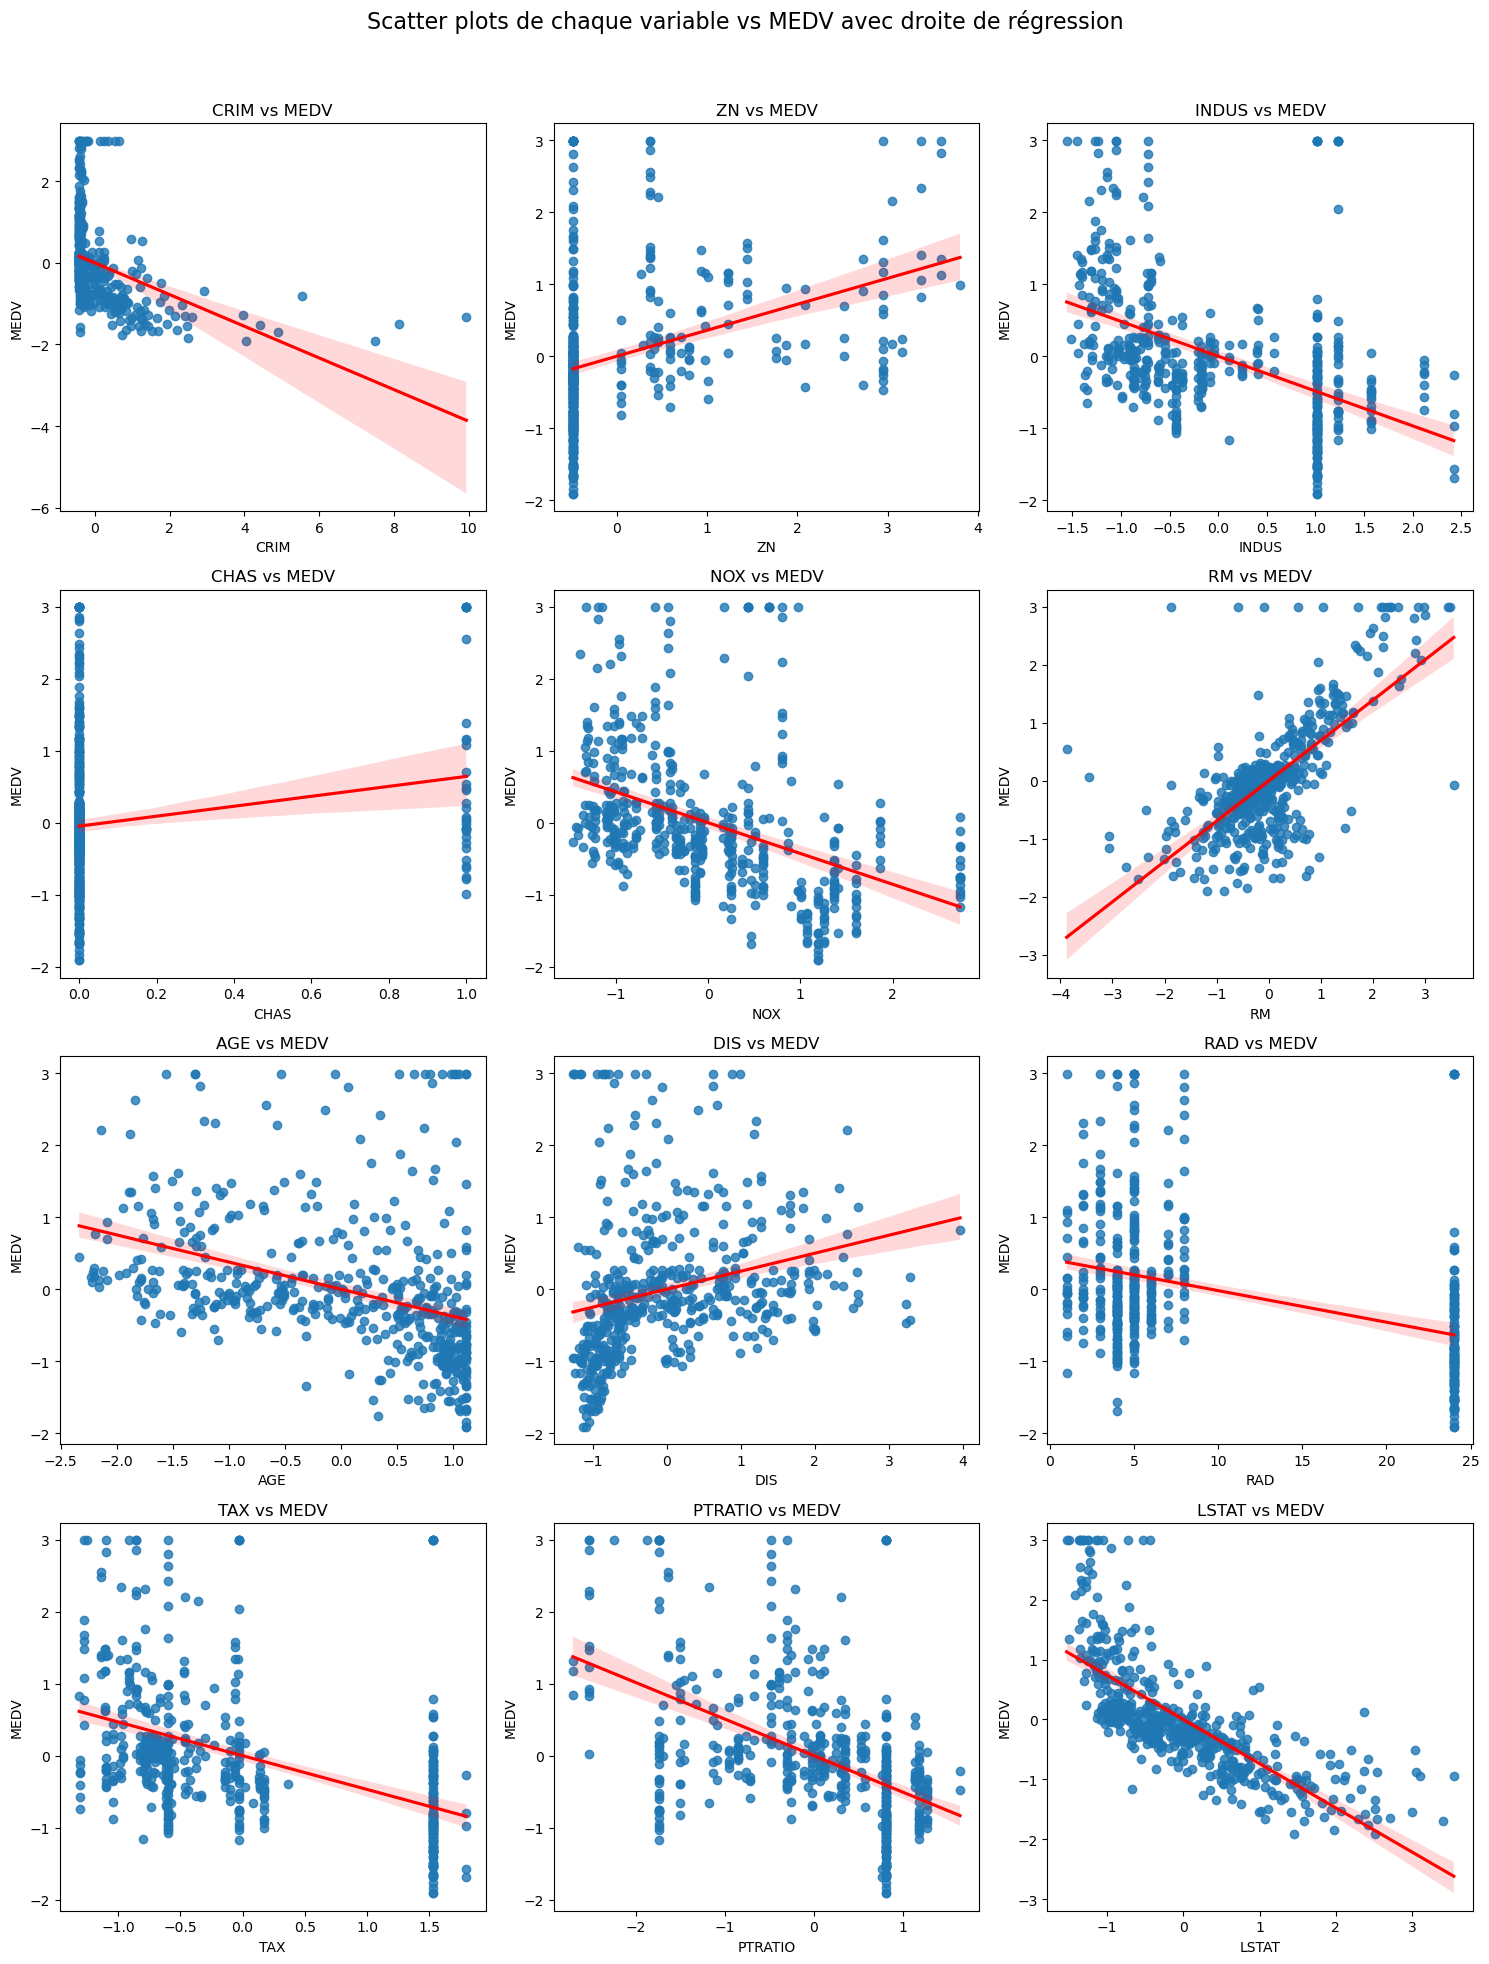

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Définir la disposition de la grille
n_cols = 3  # Nombre de colonnes souhaité
n_rows = int(np.ceil(len(features.columns) / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Taille ajustable
fig.suptitle("Scatter plots de chaque variable vs MEDV avec droite de régression", fontsize=16)

# Aplatir les axes pour pouvoir les parcourir facilement
axes = axes.flatten()

# Tracer chaque scatter plot dans une sous-figure
for i, column in enumerate(features.columns):
    sns.regplot(x=features[column], y=target, line_kws={"color": "red"}, ax=axes[i])
    axes[i].set_title(f'{column} vs MEDV')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('MEDV')

# Supprimer les sous-graphiques vides (s'il y en a)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuster la mise en page
plt.show()


### 3)Créer 2 modèles baseline, linéaire et random forest

In [11]:
features = df.drop(columns=['MEDV'])
target = df['MEDV']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Modèle de régression linéaire
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

# Modèle de random forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}")

Linear Regression MSE: 0.2781257129034743
Random Forest MSE: 0.10153357844709494


In [13]:
from sklearn.metrics import r2_score

# Calcule du R2 pour le modèle de régression linéaire
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Linear Regression R2: {r2_linear}")

# Calcule du R2 pour le modèle de random forest
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R2: {r2_rf}")



Linear Regression R2: 0.6798303833909961
Random Forest R2: 0.8831177220366218


### 4) Interpréter le modèle linéaire
Utiliser les méthodes intrinsèques du modèle pour l'interprétation

In [15]:
# Extraire les coefficients du modèle linéaire
coefficients = pd.DataFrame(linear_model.coef_, features.columns, columns=['Coefficient'])
print(coefficients)

# Ajouter l'intercept
intercept = linear_model.intercept_
print(f"Intercept: {intercept}")

         Coefficient
CRIM       -0.100159
ZN          0.087005
INDUS       0.010866
CHAS        0.340206
NOX        -0.221416
RM          0.333244
AGE        -0.019527
DIS        -0.342573
RAD         0.046541
TAX        -0.108464
PTRATIO    -0.188686
LSTAT      -0.410605
Intercept: -0.24591599099646097


In [16]:
# Trier les coefficients par importance absolue
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')

print(coefficients)


         Coefficient
LSTAT      -0.410605
DIS        -0.342573
CHAS        0.340206
RM          0.333244
NOX        -0.221416
PTRATIO    -0.188686
TAX        -0.108464
CRIM       -0.100159
ZN          0.087005
RAD         0.046541
AGE        -0.019527
INDUS       0.010866


In [ ]:
#### Chaque variable explicative (comme CRIM, ZN, INDUS, etc.........) a un coefficient associé.
### ici le coefficient est positif signifie que lorsque cette variable augmente, la cible a tendance à augmenter.
### Un coefficient négatif signifie que lorsque cette variable augmente, la cible a tendance à diminuer.

## RM (nombre moyen de pièces par logement) est de 0.333244 ainsi une augmentation d'une unité du nombre moyen 
# de pièces par logement est associée à une augmentation de 0.333 du prix prédit (en gros de la variable cible).
## LSTAT est de  -0.410065 une augmentation d'un point de pourcentage de LSTAT 
# est associée à une baisse de 0.41 du prix prédit.

### 5) Tuner votre random forest

In [17]:
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialiser le modèle RandomForest
rf = RandomForestRegressor(random_state=42)

# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Exécuter GridSearchCV
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print(f"Best parameters found: {grid_search.best_params_}")

# Utiliser le meilleur modèle pour faire des prédictions
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
print(f"Tuned Random Forest MSE: {mse_best_rf}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


c:\Users\lilou\anaconda3\envs\SVM1\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
231 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lilou\anaconda3\envs\SVM1\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lilou\anaconda3\envs\SVM1\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\lilou\anaconda3\envs\SVM1\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest MSE: 0.10274422419757503


### 6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

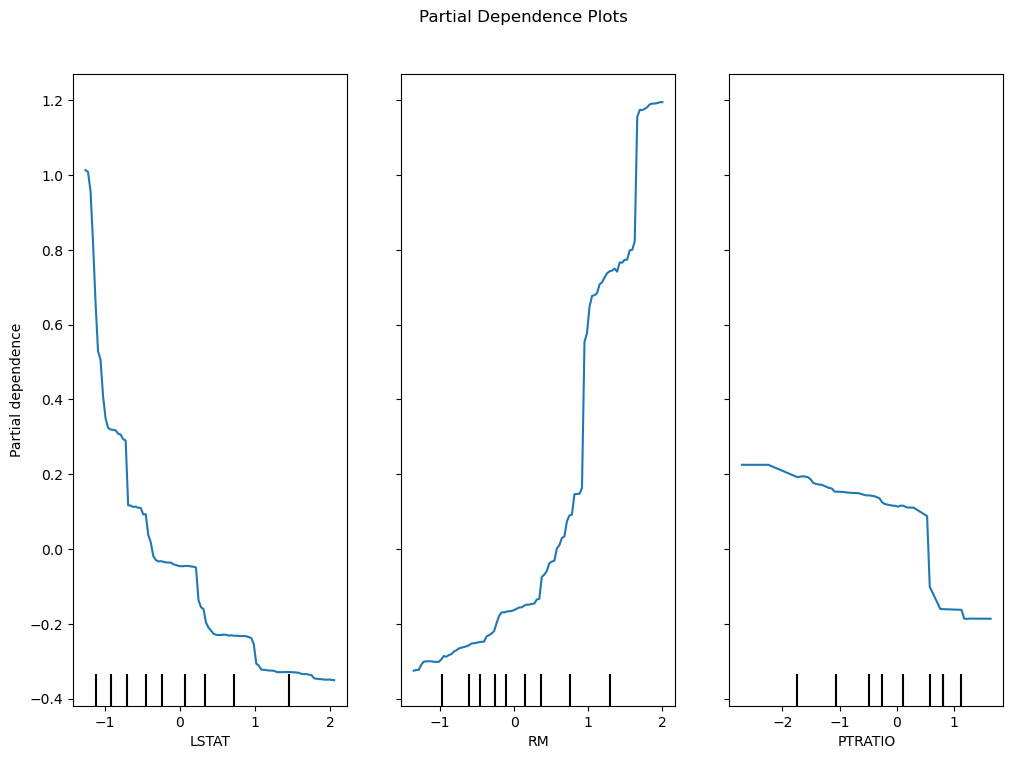

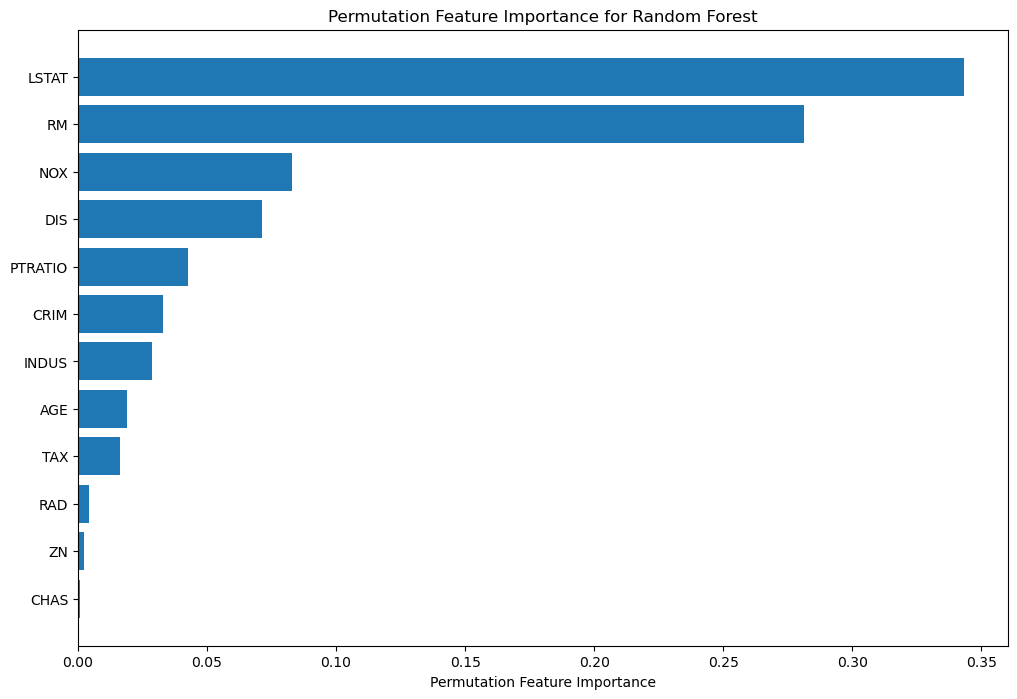

In [ ]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Partial Dependence Plots (PDP)
features_to_plot = ['LSTAT', 'RM', 'PTRATIO']
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(best_rf_model, X_train, features_to_plot, ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
plt.show()

# Permutation Feature Importance
result = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features.columns[i] for i in sorted_idx])
plt.xlabel('Permutation Feature Importance')
plt.title('Permutation Feature Importance for Random Forest')
plt.show()

In [ ]:
### oOn va avoir la même chose pour lemodèle de regression linéaire, au niveau de l'importance des variables. 
### On peu voir qu'on a un ordre qui reste approximativement les mêmes. 


### Les Partial Dependence Plots (PDP) du Random Forest révèlent des relations , à savoirLSTAT a un effet négatif marqué sur la cible, 
# et RM a une influence positive, et PTRATIO présente une relation légèrement décroissante mais non linéaire dans tous les cas. 
# L’importance des variables, mesurée par permutation, confirme que ces trois variables sont les plus influentes, ce qui est cohérent avec les coefficients du modèle linéaire. 
# Cela suggère que, malgré les différences de structure entre les deux modèles, ils identifient les mêmes variables importante

### 7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

In [ ]:
!pip install lime


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/22.7 MB ? eta -:--:--
   -------------------- ------------------- 11.5/22.7 MB 55.5 MB/s eta 0:00:01
   ---------------------------------------  22.5/22.7 MB 59.4 MB/s eta 0:00:01
   ---------------------------------------- 22.7/22.7 MB 49.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 38.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 4.2/4.2 MB 41.6 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283840 sha256=40283cbb284ee899c6f4bfd1eab0ff51f1f8feb6ce35fd4cc8309c4f747a93f4
  Stored in directory: c:\users\lilou\appdata\local\pip\cache\wheels\e6\a6\20\cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built li

In [22]:
!pip install shap

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 38.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   ----------- ---------------------------- 8.1/28.1 MB 62.9 MB/s eta 0:00:01
   ------------------------- -------------- 18.1/28.1 MB 43.9 MB/s eta 0:00:01
   ------------------------------------ --- 26.0/28.1 MB 42.2 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 37.9 MB/s eta 0:00:00


In [29]:
!pip install pdpbox

   ---------------------------------------- 0.0/35.8 MB ? eta -:--:--
   -- ------------------------------------- 2.1/35.8 MB 11.8 MB/s eta 0:00:03
   --- ------------------------------------ 3.1/35.8 MB 10.8 MB/s eta 0:00:04
   ----- ---------------------------------- 5.2/35.8 MB 8.0 MB/s eta 0:00:04
   --------- ------------------------------ 8.4/35.8 MB 10.0 MB/s eta 0:00:03
   ----------- ---------------------------- 10.5/35.8 MB 10.2 MB/s eta 0:00:03
   -------------- ------------------------- 12.6/35.8 MB 10.4 MB/s eta 0:00:03
   ---------------- ----------------------- 14.7/35.8 MB 10.6 MB/s eta 0:00:02
   --------------------- ------------------ 18.9/35.8 MB 11.1 MB/s eta 0:00:02
   ----------------------- ---------------- 21.0/35.8 MB 11.2 MB/s eta 0:00:02
   ------------------------ --------------- 22.0/35.8 MB 11.2 MB/s eta 0:00:02
   ----------------------------- ---------- 26.2/35.8 MB 11.1 MB/s eta 0:00:01
   ----------------------------- ---------- 26.2/35.8 MB 11.1 MB/s

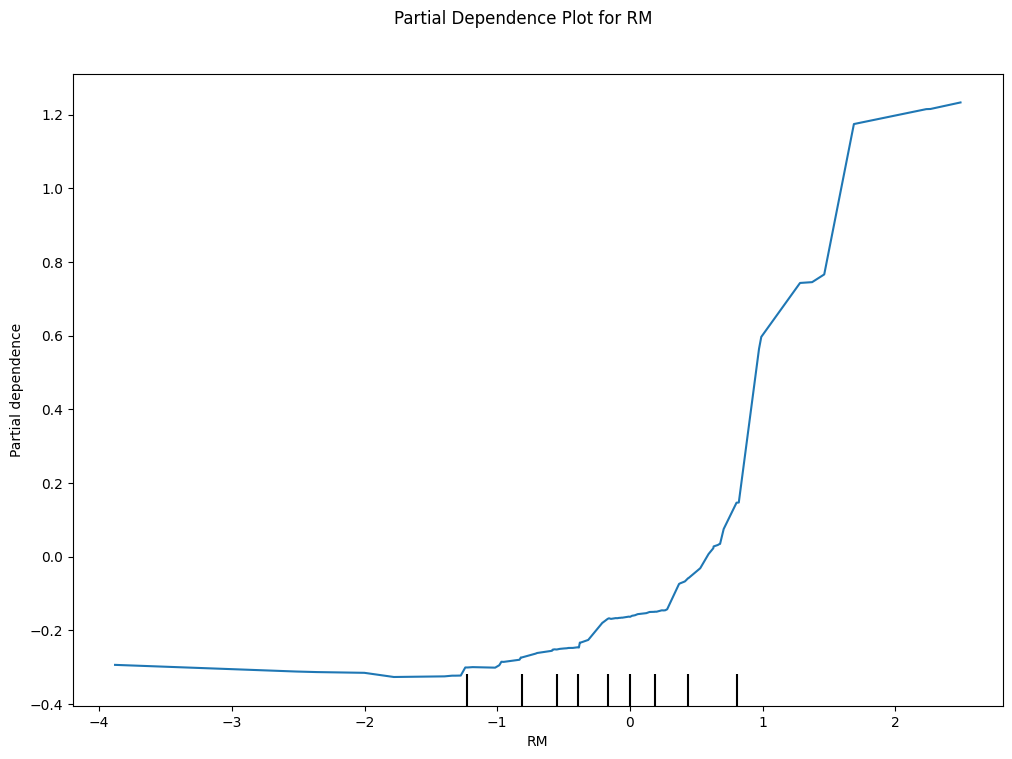

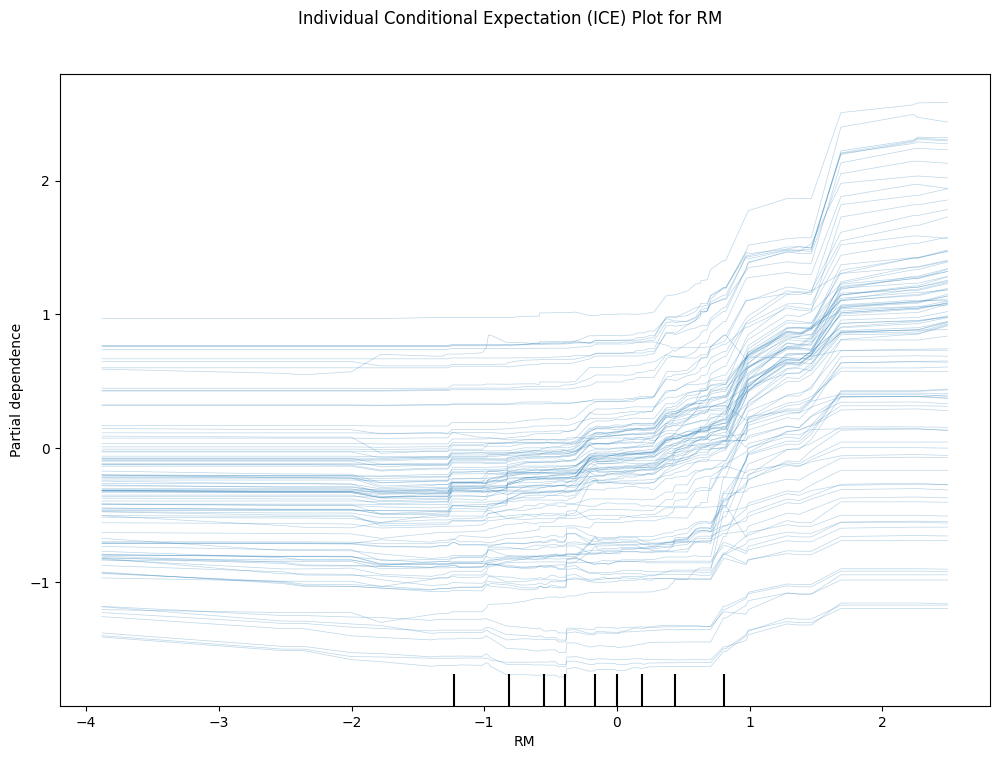

In [31]:
from sklearn.inspection import PartialDependenceDisplay

# PDP for RM
features_to_plot = ['RM']
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(best_rf_model, X_test, features_to_plot, ax=ax)
plt.suptitle('Partial Dependence Plot for RM')
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
plt.show()

# ICE for RM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(best_rf_model, X_test, features_to_plot, ax=ax, kind='individual')
plt.suptitle('Individual Conditional Expectation (ICE) Plot for RM')
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
plt.show()

In [ ]:
#### On peut voir que la courbe pour ICE est similaire à PDP mais avec plus de détails. 
#  Mais dans l'ensemble les deux sont similaires, donc pdd n'a pas l'air de masquer des info importantes

In [33]:
from lime.lime_tabular import LimeTabularExplainer

# Création de l'explainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='regression')

# Explication d'un individu 
idx = 12
exp = explainer.explain_instance(X_test.iloc[idx].values, rf_model.predict)

# Affichage
exp.show_in_notebook()


In [ ]:
## Poids par variable, poiur un individu donné (12) on a le plus gros poids fait par LSTAT, c'est cohérent

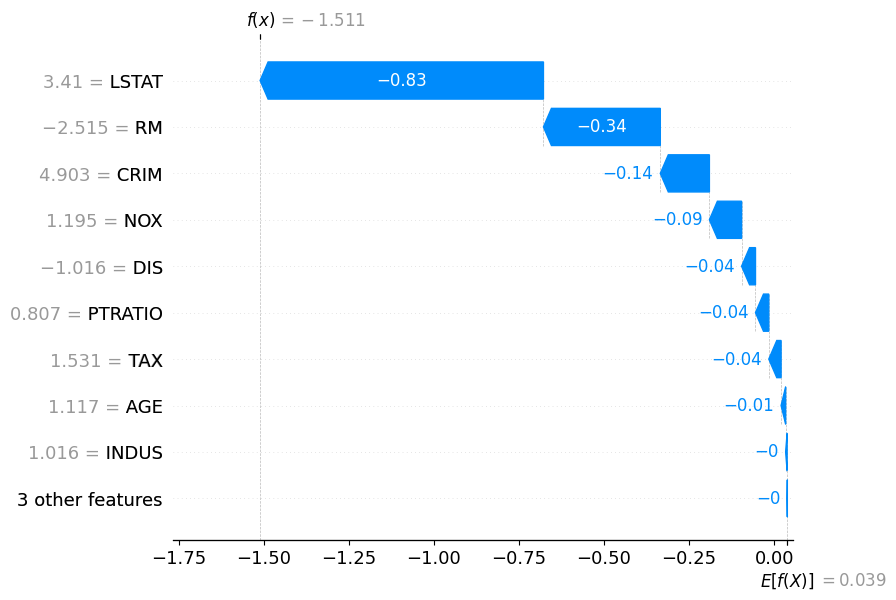

In [35]:
import shap

# Création des valeurs SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Waterfall plot pour un individu
idx = 12
shap.waterfall_plot(shap.Explanation(values=shap_values[idx], 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[idx]))


In [ ]:
### la on peut voir comment chaque variable contribue à la prédiction d'un individu 
# c'est interessant on voit que c'est toujours LSTAT et on descend de plus en plus
#  c'ets logique avec l'analyse ultérieur

### 8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

In [26]:
import matplotlib.pyplot as plt

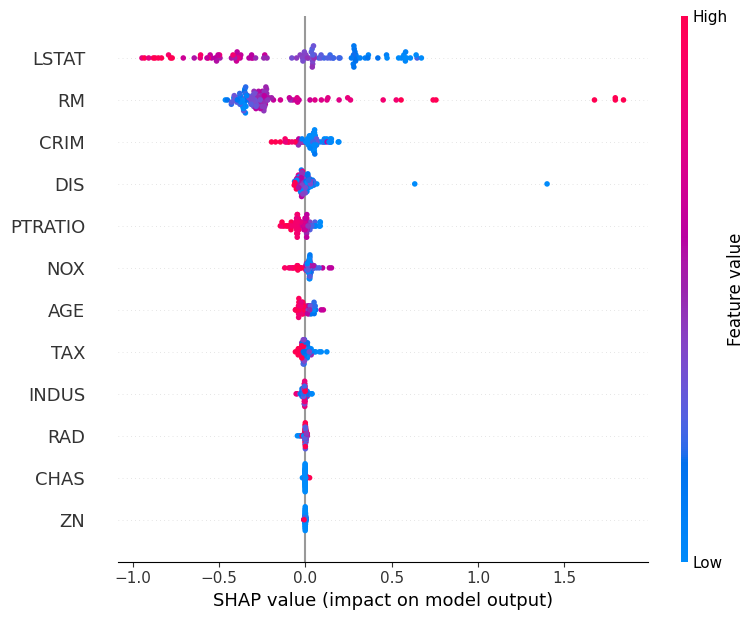

In [36]:
import shap

# Création des valeurs SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Beeswarm plot
shap.summary_plot(shap_values, X_test)


In [ ]:
### Le beeswarm plot montre l'impact des variables sur les prédictions. 
# Il permet de visualiser l'importance de chaque variable et sa distribution ou chaque points représente un individu
## On peut voir que plus on va vers le rouge plus on voit l'impact de sa prédiction, cela concorde avec l'analyse au dessus 
### c'est toujours LSTAT et RM qui impact le plus et qui ont beaucoup de points rouges et de manière étendue

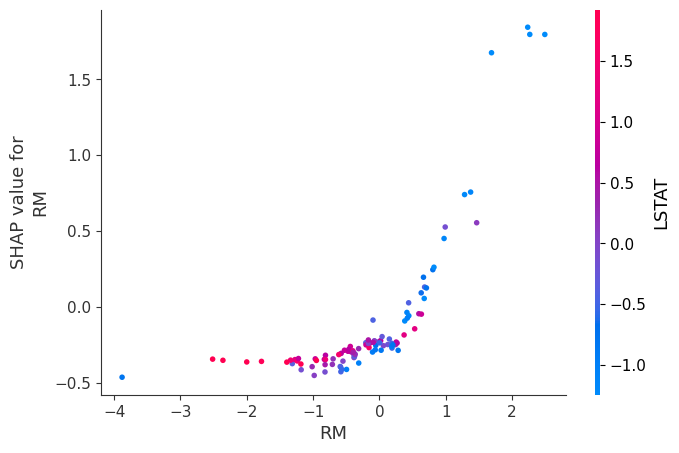

In [37]:
# Scatter plot pour une variable importante, par ex. 'RM'
shap.dependence_plot('RM', shap_values, X_test)


In [ ]:
## L'axe X est la valeur réelle de la variable, 
# l’axe Y est son impact sur la prédiction. 
# La couleur représente une autre variable corrélée automatiquement choisie par SHAP.
## On va avoir l'impact de RM sur la prédiction qui est d'abord négatif, puis positif à partir d'un certain seuil
###Possible explication si pour un faible nombre de pièces par logement, la prédiction de prix est négative. 
# Puis, à partir d'un certain nombre de pièces , l'impact devient positif.